# Diffusion Model Pipeline

This notebook covers the following steps:
1. Data Acquisition
2. Data Analysis
3. Data Cleansing and Preparation

In [1]:
import os
import requests
import zipfile
from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import Flowers102, CelebA
import scipy
import gdown

## 1. Data Acquisition

In [3]:
def download_file(url, filename):
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 KB

    with open(filename, 'wb') as file, tqdm(
        desc=filename,
        total=total_size,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as progress_bar:
        for data in response.iter_content(block_size):
            size = file.write(data)
            progress_bar.update(size)

#def acquire_celeba():
#    #url = "https://drive.google.com/uc?export=download&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM"
#    zip_path = "celeba.zip"
#    extract_path = "celeba"
#    url = "https://drive.google.com/uc?export=download&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM"
#    #output = "fcn8s_from_caffe.npz"
#
#    print("Downloading CelebA dataset...")
#    #download_file(url, zip_path)
#    gdown.download(url, zip_path)
#
#    print("Extracting CelebA dataset...")
#    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#        zip_ref.extractall(extract_path)
#
#    os.remove(zip_path)
#    print("CelebA dataset acquired and extracted.")

def acquire_flowers102():
    print("Downloading Flowers102 dataset...")
    Flowers102(root='./data', download=True)
    print("Flowers102 dataset acquired.")

def acquire_celeba2():
    print("Downloading CelebA dataset...")
    CelebA(root='./data', download=True)
    print("CelebA dataset acquired.")


In [3]:
acquire_flowers102()

100%|██████████| 344862509/344862509 [01:10<00:00, 4912935.05it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 259590.75it/s]


100%|██████████| 14989/14989 [00:00<00:00, 12397638.07it/s]

Flowers102 dataset acquired.


In [ ]:
acquire_celeba2()
# If you get the FileURLRetrievalError, that means the daily quota for google drive download is exceeded, download the img_align_celeba.zip file from this drive link manually:
#https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ
#and also all the txt files, listed here in the file_list:
#https://pytorch.org/vision/main/_modules/torchvision/datasets/celeba.html#:~:text=%23%20right%20now.-,file_list,-%3D%20%5B%0A%20%20%20%20%20%20%20%20%23%20File
#and after its downloaded, unzip img_align_celeba.zip to data/celeba (takes like 1 hour, 200k pictures)
#Dir structure should look like this (jpeg pictures in dir):
#--data/
#---celeba/
#----img_align_celeba
#----identity_CelebA.txt
#----list_attr_celeba.txt
#----list_bbox_celeba.txt
#----list_eval_partition.txt
#----list_landmarks_align_celeba.txt
#----list_landmarks_celeba.txt


## 2. Data Analysis

In [5]:
def analyze_dataset(dataset_path, is_flowers=False):
    if is_flowers:
        dataset = Flowers102(root=dataset_path, download=False)
        images = [dataset[i][0] for i in range(len(dataset))]
    else:
        #dataset = CelebA(root=dataset_path, download=False)
        dataset=CelebA(root=dataset_path, download=False)
        images = [dataset[i][0] for i in range(len(dataset))]
        #images = [Image.open(os.path.join(dataset_path, f)) for f in os.listdir(dataset_path) if f.endswith('.jpg')]

    sizes = [img.size for img in images]
    aspects = [w/h for w, h in sizes]
    
    print(f"Total images: {len(images)}")
    print(f"Average size: {np.mean(sizes, axis=0)}")
    print(f"Size std dev: {np.std(sizes, axis=0)}")
    print(f"Average aspect ratio: {np.mean(aspects)}")
    
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.hist([s[0] for s in sizes], bins=50)
    plt.title('Width Distribution')
    plt.subplot(122)
    plt.hist([s[1] for s in sizes], bins=50)
    plt.title('Height Distribution')
    plt.tight_layout()
    plt.show()
    
    plt.figure()
    plt.hist(aspects, bins=50)
    plt.title('Aspect Ratio Distribution')
    plt.show()

# Uncomment these lines to analyze the datasets
# analyze_dataset("./data/celeba/img_align_celeba")
# analyze_dataset("./data", is_flowers=True)

In [ ]:
analyze_dataset("./data")

Total images: 1020
Average size: [624.48921569 537.7754902 ]
Size std dev: [97.37465991 79.19704631]
Average aspect ratio: 1.1943896536225806


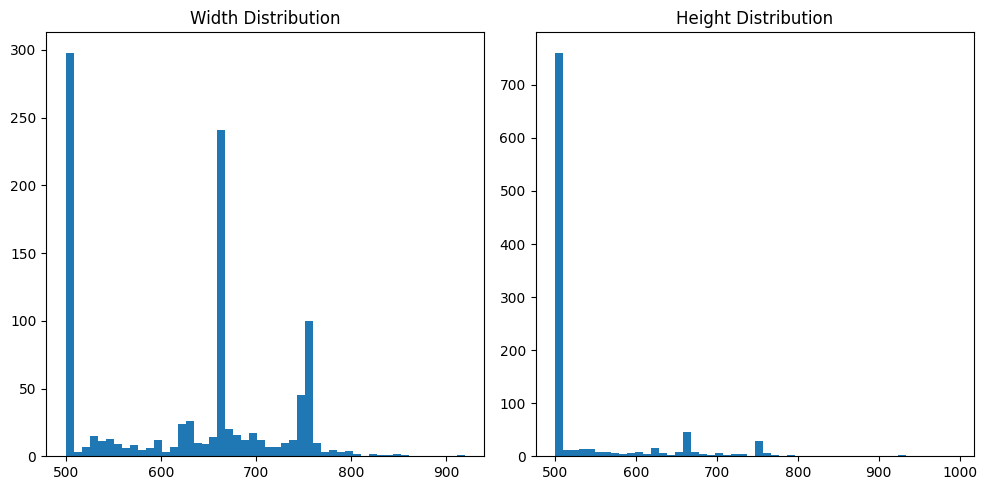

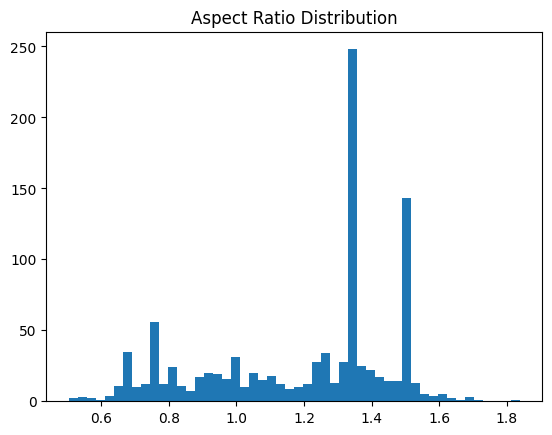

In [4]:
analyze_dataset("./data", is_flowers=True)

## 3. Data Cleansing and Preparation

In [8]:
#class CelebADataset(Dataset):
#    def __init__(self, root_dir, transform=None):
#        self.root_dir = root_dir
#        self.transform = transform
#        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]
#
#    def __len__(self):
#        return len(self.image_files)
#
#    def __getitem__(self, idx):
#        img_name = os.path.join(self.root_dir, self.image_files[idx])
#        image = Image.open(img_name).convert('RGB')
#        
#        if self.transform:
#            image = self.transform(image)
#        
#        return image

def prepare_data(dataset_path, is_flowers=False, image_size=64, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    if is_flowers:
        dataset = Flowers102(root=dataset_path, download=False, transform=transform)
    else:
        #dataset = CelebADataset(dataset_path, transform=transform)
        dataset = CelebA(root=dataset_path, download=False, transform=transform)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    return dataloader

def clean_data(dataloader):
    cleaned_images = []
    for batch in dataloader:
        # Remove any images with NaN or Inf values
        mask = torch.isfinite(batch).all(dim=(1, 2, 3))
        cleaned_images.append(batch[mask])
    
    return torch.cat(cleaned_images, dim=0)

# Uncomment these lines to prepare and clean the datasets
# celeba_loader = prepare_data("./celeba/img_align_celeba", is_flowers=False)
# flowers_loader = prepare_data("./data", is_flowers=True)

# cleaned_celeba = clean_data(celeba_loader)
# cleaned_flowers = clean_data(flowers_loader)

# print(f"Cleaned CelebA dataset size: {cleaned_celeba.shape}")
# print(f"Cleaned Flowers102 dataset size: {cleaned_flowers.shape}")

# # Save cleaned datasets
# torch.save(cleaned_celeba, "cleaned_celeba.pt")
# torch.save(cleaned_flowers, "cleaned_flowers.pt")

In [12]:
flowers_loader = prepare_data("./data", is_flowers=True)
print(type(flowers_loader))
cleaned_flowers = clean_data(flowers_loader)
print(f"Cleaned Flowers102 dataset size: {cleaned_flowers.shape}")
torch.save(cleaned_flowers, "cleaned_flowers.pt")

<class 'torch.utils.data.dataloader.DataLoader'>


TypeError: isfinite(): argument 'input' (position 1) must be Tensor, not list